In [1]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import os
import time
from collections import defaultdict
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score,roc_curve
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

* The symptoms included are as follows:

In [2]:
symptoms = ['intercept',
            'fever',
            'sorethroat',
            'cough',
            'muscle',
            'headache',
            'fatigue',
            'vomit',
            'nausea',
            'diarrhea',
            'chills',
            'sneeze',
            'shortness of breath',
            'phlegm',
            'blockednose',
            'earache',
            'leg pain',
            'runnynose',
            'virus']

In [3]:
def read_file(filename):
    data = pd.read_csv(filename)
    data['intercept'] = 1
    columns = list(data.columns)
    columns = columns[-1:] + columns[:-1]
    data = data[columns]
    data = data[symptoms]
    train_data = data.drop(['virus'],axis =1).as_matrix()
    return data,train_data

In [4]:
def read_parameters(filename):
    parameters = pd.read_csv(filename)
    return parameters

#### Get the parameters for the different dataset combinations

In [5]:
directory_ = "./Generated_Parameters_3/"
only_symptoms_ = ['only_symptoms_nyumc.csv','only_symptoms_goviral.csv','only_symptoms_fluwatch.csv','only_symptoms_hongkong.csv','only_symptoms_hutterite.csv']
with_demographics_ = ['with_demographics_nyumc.csv','with_demographics_goviral.csv','with_demographics_fluwatch.csv','with_demographics_hongkong.csv','with_demographics_hutterite.csv']
only_symptoms_parameters = defaultdict()
with_demographic_parameters = defaultdict()

In [6]:
def return_parameters(file,dataset_names):
    param = read_parameters(file)
    parameter_dict = defaultdict()
    for i in dataset_names:
        parameter_dict[i] = list(param[i])
    return parameter_dict
    

In [7]:
def get_parameters(dataset_name,parameters):
    return np.array(list(parameters[dataset_name]))

In [8]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [9]:
def get_results(param,sample_points):
    return sigmoid(np.dot(param,sample_points.T)  )

In [10]:
def save_results_for_finding_threshold(filename,dataframe,predicted):
    results = pd.DataFrame()
    results['Actual'] = dataframe['virus']
    results['Predicted'] = predicted
    print(results.head())
    results.to_csv(filename,index = False)

In [11]:
def get_all_datasets(training_data_):
    datasets = defaultdict()
    for i in training_data_:
        data,training = read_file(training_directory+i)
        datasets[i[:-4]] = (data,training)
    return datasets

In [12]:
def get_all_results(data_dict,param):
    results = defaultdict()
    for i in list(param.keys()):
        data,train = data_dict[i]
        results[i] = get_results(param[i],train)
    return results

In [13]:
def result_statistics(list_):
#     print("Min : ",min(list_))
#     print("Max : ",max(list_))
#     print("Mean : ",np.mean(list_))
#     print("Standard Deviation : ",np.std(list_))
    return min(list_),max(list_)

In [14]:
def return_class(threshold,list_):
    ans = list_ >= threshold * 1
    return [int(i) for i in ans]

def metrics_pred(list1,list2):
    f1 =f1_score(list1,list2)
    precision = precision_score(list1,list2)
    recall = recall_score(list1,list2)
    accuracy = accuracy_score(list1,list2)
    fpr,tpr,threshold = roc_curve(list1,list2)
    auc = metrics.auc(fpr,tpr)
#     print("f1 score : ",f1)
#     print("Precision score : ",precision)
#     print("Recall : ",recall)
#     print("Accuracy : ",accuracy)
#     print("Area under the curve : ",auc)
    return auc

In [15]:
def find_threshold(min_,max_,list1,list2,step_size = 1e-3):
    auc_thresholds = defaultdict()
    value = min_
    while value < max_:
        auc_thresholds[value] = metrics_pred(list1['virus'],return_class(value,list2))
        value += step_size
    optimal_threshold = max(auc_thresholds.items(), key=lambda x: x[1]) 
    return optimal_threshold

In [16]:
def return_all_thresholds(results,data):
    thresholds = defaultdict()
    for i in list(data.keys()):
        print("_____________________")
        print(i)
        min_,max_ = result_statistics(results[i])
        threshold = find_threshold(min_,max_,data[i][0],results[i])
        print("Found threshold for : ",i)
        thresholds[i] = threshold
    return thresholds

In [17]:
def test(filename_,param,thresholds_):
    aucs = defaultdict()
    data,train = read_file(filename_)
    for i in list(param.keys()):
        test_results = get_results(param[i],train)
        auc_ = metrics_pred(data['virus'],return_class(thresholds_[i][0],test_results))
        aucs[i] = auc_
    return aucs

In [18]:
def return_final_auc_scores(training_data_,training_directory,filename_,parameters):
    data = get_all_datasets(training_data_)
    results = get_all_results(data,parameters)
    #find the thresholds
    thresholds = return_all_thresholds(results,data)
    #get the auc values
    aucs_= test(filename_,parameters,thresholds)
    return aucs_


In [19]:
def create_dict(dict_):
    temp = []
    for k,v in dict_.items():
        temp.append((k,v))
    return temp
        

In [20]:
results_symp = defaultdict()
results_demo = defaultdict()

#### Get the symptoms

In [21]:
symp_nyumc = return_parameters(directory_+only_symptoms_[0],['goviral','fluwatch','hongkong','hutterite'])
symp_goviral = return_parameters(directory_+only_symptoms_[1],['nyumc','fluwatch','hongkong','hutterite'])
symp_fluwatch = return_parameters(directory_+only_symptoms_[2],['nyumc','goviral','hongkong','hutterite'])
symp_hongkong = return_parameters(directory_+only_symptoms_[3],['nyumc','goviral','fluwatch','hutterite'])
symp_hutterite = return_parameters(directory_+only_symptoms_[4],['nyumc','goviral','fluwatch','hongkong'])
demo_nyumc = return_parameters(directory_+with_demographics_[0],['goviral','fluwatch','hongkong','hutterite'])
demo_goviral = return_parameters(directory_+with_demographics_[1],['nyumc','fluwatch','hongkong','hutterite'])
demo_fluwatch = return_parameters(directory_+with_demographics_[2],['nyumc','goviral','hongkong','hutterite'])
demo_hongkong = return_parameters(directory_+with_demographics_[3],['nyumc','goviral','fluwatch','hutterite'])
demo_hutterite = return_parameters(directory_+with_demographics_[4],['nyumc','goviral','fluwatch','hongkong'])


#### Only symptoms

##### NYUMC not considered in the training data

In [22]:
training_data_nyumc = ['goviral.csv','fluwatch.csv','hongkong.csv','hutterite.csv']
training_directory = "../../Data/With_Improved_Target/With_Demographics/"
filename_ = "../../Data/With_Improved_Target/With_Demographics/goviral.csv"

In [23]:
print("Only symptoms")
aucs_nyumc_sym = return_final_auc_scores(training_data_nyumc,training_directory,filename_,symp_nyumc)
aucs_nyumc_sym

Only symptoms
_____________________
goviral
Found threshold for :  goviral
_____________________
fluwatch
Found threshold for :  fluwatch
_____________________
hongkong
Found threshold for :  hongkong
_____________________
hutterite
Found threshold for :  hutterite


defaultdict(None,
            {'fluwatch': 0.70000300124551695,
             'goviral': 0.76933927579945682,
             'hongkong': 0.70083584687645373,
             'hutterite': 0.75867735110070678})

In [24]:
results_symp['goviral'] = create_dict(aucs_nyumc_sym)
results_symp['goviral']

[('goviral', 0.76933927579945682),
 ('fluwatch', 0.70000300124551695),
 ('hongkong', 0.70083584687645373),
 ('hutterite', 0.75867735110070678)]

In [25]:
print("With demographics")
aucs_nyumc_demo = return_final_auc_scores(training_data_nyumc,training_directory,filename_,demo_nyumc)
aucs_nyumc_demo

With demographics
_____________________
goviral
Found threshold for :  goviral
_____________________
fluwatch
Found threshold for :  fluwatch
_____________________
hongkong
Found threshold for :  hongkong
_____________________
hutterite
Found threshold for :  hutterite


defaultdict(None,
            {'fluwatch': 0.70000300124551695,
             'goviral': 0.76933927579945682,
             'hongkong': 0.70083584687645373,
             'hutterite': 0.75867735110070678})

In [26]:
results_demo['goviral'] = create_dict(aucs_nyumc_demo)
results_demo['goviral']

[('goviral', 0.76933927579945682),
 ('fluwatch', 0.70000300124551695),
 ('hongkong', 0.70083584687645373),
 ('hutterite', 0.75867735110070678)]

##### Goviral not considered in training data

In [27]:
training_data_goviral = ['nyumc.csv','fluwatch.csv','hongkong.csv','hutterite.csv']
training_directory = "../../Data/With_Improved_Target/With_Demographics/"
filename_ = "../../Data/With_Improved_Target/With_Demographics/nyumc.csv"


In [28]:
print("Only Symptoms")
aucs_goviral_sym = return_final_auc_scores(training_data_goviral,training_directory,filename_,symp_goviral)
aucs_goviral_sym

Only Symptoms
_____________________
nyumc
Found threshold for :  nyumc
_____________________
fluwatch
Found threshold for :  fluwatch
_____________________
hongkong
Found threshold for :  hongkong
_____________________
hutterite
Found threshold for :  hutterite


defaultdict(None,
            {'fluwatch': 0.5,
             'hongkong': 0.64554624987492326,
             'hutterite': 0.91542529017165486,
             'nyumc': 0.89035532994923861})

In [29]:
results_symp['nyumc'] = create_dict(aucs_goviral_sym)

In [30]:
results_symp['nyumc']

[('nyumc', 0.89035532994923861),
 ('fluwatch', 0.5),
 ('hongkong', 0.64554624987492326),
 ('hutterite', 0.91542529017165486)]

In [31]:
print("With demographics")
aucs_goviral_demo = return_final_auc_scores(training_data_goviral,training_directory,filename_,demo_goviral)

With demographics
_____________________
nyumc
Found threshold for :  nyumc
_____________________
fluwatch
Found threshold for :  fluwatch
_____________________
hongkong
Found threshold for :  hongkong
_____________________
hutterite
Found threshold for :  hutterite


In [32]:
aucs_goviral_demo

defaultdict(None,
            {'fluwatch': 0.5,
             'hongkong': 0.64554624987492326,
             'hutterite': 0.91542529017165486,
             'nyumc': 0.89035532994923861})

In [33]:
results_demo['nyumc'] = create_dict(aucs_goviral_demo)

In [34]:
results_demo['nyumc']

[('nyumc', 0.89035532994923861),
 ('fluwatch', 0.5),
 ('hongkong', 0.64554624987492326),
 ('hutterite', 0.91542529017165486)]

#### FluWatch not considered in training data

In [35]:
training_data_fluwatch = ['nyumc.csv','goviral.csv','hongkong.csv','hutterite.csv']
training_directory = "../../Data/With_Improved_Target/With_Demographics/"
filename_ = "../../Data/With_Improved_Target/With_Demographics/hongkong.csv"


In [36]:
print("Only Symptoms")
aucs_fluwatch_sym = return_final_auc_scores(training_data_fluwatch,training_directory,filename_,symp_fluwatch)


Only Symptoms
_____________________
nyumc
Found threshold for :  nyumc
_____________________
goviral
Found threshold for :  goviral
_____________________
hongkong
Found threshold for :  hongkong
_____________________
hutterite
Found threshold for :  hutterite


In [37]:
results_symp['hongkong'] = create_dict(aucs_fluwatch_sym)
results_symp['hongkong']

[('nyumc', 0.50509857239972811),
 ('goviral', 0.68986978219741879),
 ('hongkong', 0.97990238300315813),
 ('hutterite', 0.95329426623594493)]

In [38]:
print("With demographics")
aucs_fluwatch_demo = return_final_auc_scores(training_data_fluwatch,training_directory,filename_,demo_fluwatch)
aucs_fluwatch_demo

With demographics
_____________________
nyumc
Found threshold for :  nyumc
_____________________
goviral
Found threshold for :  goviral
_____________________
hongkong
Found threshold for :  hongkong
_____________________
hutterite
Found threshold for :  hutterite


defaultdict(None,
            {'goviral': 0.68986978219741879,
             'hongkong': 0.97990238300315813,
             'hutterite': 0.95329426623594493,
             'nyumc': 0.50509857239972811})

In [39]:
results_demo['hongkong']= create_dict(aucs_fluwatch_demo)
results_demo['hongkong']

[('nyumc', 0.50509857239972811),
 ('goviral', 0.68986978219741879),
 ('hongkong', 0.97990238300315813),
 ('hutterite', 0.95329426623594493)]

##### Hongkong not considered in training data

In [40]:
training_data_hongkong = ['nyumc.csv','goviral.csv','fluwatch.csv','hutterite.csv']
training_directory = "../../Data/With_Improved_Target/With_Demographics/"
filename_ = "../../Data/With_Improved_Target/With_Demographics/hutterite.csv"

In [41]:
print("Only Symptoms")
aucs_hongkong_sym = return_final_auc_scores(training_data_hongkong,training_directory,filename_,symp_hongkong)
aucs_hongkong_sym

Only Symptoms
_____________________
nyumc
Found threshold for :  nyumc
_____________________
goviral
Found threshold for :  goviral
_____________________
fluwatch
Found threshold for :  fluwatch
_____________________
hutterite
Found threshold for :  hutterite


defaultdict(None,
            {'fluwatch': 0.51178950455015459,
             'goviral': 0.58303324776607734,
             'hutterite': 0.7454086908209826,
             'nyumc': 0.50254129606099107})

In [42]:
results_symp['hutterite']= create_dict(aucs_hongkong_sym)
results_symp['hutterite']

[('nyumc', 0.50254129606099107),
 ('goviral', 0.58303324776607734),
 ('fluwatch', 0.51178950455015459),
 ('hutterite', 0.7454086908209826)]

In [43]:
print("With Demographics")
aucs_hongkong_demo = return_final_auc_scores(training_data_hongkong,training_directory,filename_,demo_hongkong)
aucs_hongkong_demo

With Demographics
_____________________
nyumc
Found threshold for :  nyumc
_____________________
goviral
Found threshold for :  goviral
_____________________
fluwatch
Found threshold for :  fluwatch
_____________________
hutterite
Found threshold for :  hutterite


defaultdict(None,
            {'fluwatch': 0.51178950455015459,
             'goviral': 0.58303324776607734,
             'hutterite': 0.7454086908209826,
             'nyumc': 0.50254129606099107})

In [44]:
results_demo['hutterite'] = aucs_hongkong_demo

##### Hutterite not considered in training data

In [45]:
training_data_hutterite = ['nyumc.csv','goviral.csv','fluwatch.csv','hongkong.csv']
training_directory = "../../Data/With_Improved_Target/With_Demographics/"
filename_ = "../../Data/With_Improved_Target/With_Demographics/fluwatch.csv"

In [46]:
print("Only Symptoms")
aucs_hutterite_sym = return_final_auc_scores(training_data_hutterite,training_directory,filename_,symp_hutterite)
aucs_hutterite_sym

Only Symptoms
_____________________
nyumc
Found threshold for :  nyumc
_____________________
goviral
Found threshold for :  goviral
_____________________
fluwatch
Found threshold for :  fluwatch
_____________________
hongkong
Found threshold for :  hongkong


defaultdict(None,
            {'fluwatch': 0.63447211579395479,
             'goviral': 0.59071489387581333,
             'hongkong': 0.50133035334184761,
             'nyumc': 0.49568965517241381})

In [47]:
results_symp['fluwatch'] = create_dict(aucs_hutterite_sym)

In [48]:
print("With Demographics")
aucs_hutterite_demo = return_final_auc_scores(training_data_hutterite,training_directory,filename_,demo_hutterite)
aucs_hutterite_demo

With Demographics
_____________________
nyumc
Found threshold for :  nyumc
_____________________
goviral
Found threshold for :  goviral
_____________________
fluwatch
Found threshold for :  fluwatch
_____________________
hongkong
Found threshold for :  hongkong


defaultdict(None,
            {'fluwatch': 0.63447211579395479,
             'goviral': 0.59071489387581333,
             'hongkong': 0.50133035334184761,
             'nyumc': 0.49568965517241381})

In [49]:
results_demo['fluwatch'] = create_dict(aucs_hutterite_demo)

In [50]:
results_symp

defaultdict(None,
            {'fluwatch': [('nyumc', 0.49568965517241381),
              ('goviral', 0.59071489387581333),
              ('fluwatch', 0.63447211579395479),
              ('hongkong', 0.50133035334184761)],
             'goviral': [('goviral', 0.76933927579945682),
              ('fluwatch', 0.70000300124551695),
              ('hongkong', 0.70083584687645373),
              ('hutterite', 0.75867735110070678)],
             'hongkong': [('nyumc', 0.50509857239972811),
              ('goviral', 0.68986978219741879),
              ('hongkong', 0.97990238300315813),
              ('hutterite', 0.95329426623594493)],
             'hutterite': [('nyumc', 0.50254129606099107),
              ('goviral', 0.58303324776607734),
              ('fluwatch', 0.51178950455015459),
              ('hutterite', 0.7454086908209826)],
             'nyumc': [('nyumc', 0.89035532994923861),
              ('fluwatch', 0.5),
              ('hongkong', 0.64554624987492326),
              ('hutt

In [51]:
results_demo

defaultdict(None,
            {'fluwatch': [('nyumc', 0.49568965517241381),
              ('goviral', 0.59071489387581333),
              ('fluwatch', 0.63447211579395479),
              ('hongkong', 0.50133035334184761)],
             'goviral': [('goviral', 0.76933927579945682),
              ('fluwatch', 0.70000300124551695),
              ('hongkong', 0.70083584687645373),
              ('hutterite', 0.75867735110070678)],
             'hongkong': [('nyumc', 0.50509857239972811),
              ('goviral', 0.68986978219741879),
              ('hongkong', 0.97990238300315813),
              ('hutterite', 0.95329426623594493)],
             'hutterite': defaultdict(None,
                         {'fluwatch': 0.51178950455015459,
                          'goviral': 0.58303324776607734,
                          'hutterite': 0.7454086908209826,
                          'nyumc': 0.50254129606099107}),
             'nyumc': [('nyumc', 0.89035532994923861),
              ('fluwatch', 0.5

In [52]:
def create_plots(columns,dict_,name,order,label,title):
    columns = list(dict_.keys())
    df = pd.DataFrame(columns)
    df_list = []
    for i in dict_.keys():
        df_list.append(pd.DataFrame({k:[v] for (k,v) in dict(dict_[i]).items()}))
    df = pd.concat(df_list)
#     df.fillna(0,inplace = True)
    df[name] = columns
    df.set_index(name,inplace = True)
    df = df[list(dict_.keys())]
    df = df[columns[::-1]]
    print(df)
    sns.set()
    ax = plt.axes()
    sns.heatmap(df,annot=True,linewidth = 0.8,ax = ax,cbar_kws = {'label' : label},cbar = 'purple',fmt='f')
    ax.set_title(title)
    ax.set_xlabel('Predicted using datatset')
    plt.show()
    return df
    

              fluwatch  hutterite  hongkong     nyumc   goviral
Test Dataset                                                   
goviral       0.700003   0.758677  0.700836       NaN  0.769339
nyumc         0.500000   0.915425  0.645546  0.890355       NaN
hongkong           NaN   0.953294  0.979902  0.505099  0.689870
hutterite     0.511790   0.745409       NaN  0.502541  0.583033
fluwatch      0.634472        NaN  0.501330  0.495690  0.590715


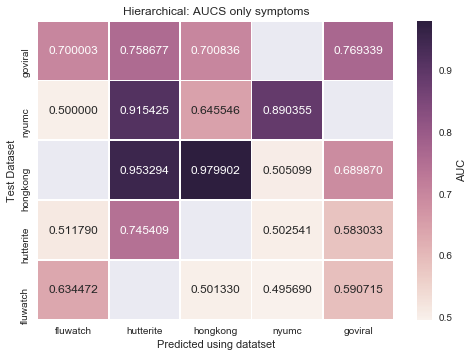

In [53]:
positive_distances = create_plots(['nyumc','goviral','fluwatch','hongkong','hutterite'],
                  results_symp,
                  'Test Dataset',
                  ['hutterite','hongkong','fluwatch','goviral','nyumc'],'AUC',
                  'Hierarchical: AUCS only symptoms')

In [54]:
results_demo

defaultdict(None,
            {'fluwatch': [('nyumc', 0.49568965517241381),
              ('goviral', 0.59071489387581333),
              ('fluwatch', 0.63447211579395479),
              ('hongkong', 0.50133035334184761)],
             'goviral': [('goviral', 0.76933927579945682),
              ('fluwatch', 0.70000300124551695),
              ('hongkong', 0.70083584687645373),
              ('hutterite', 0.75867735110070678)],
             'hongkong': [('nyumc', 0.50509857239972811),
              ('goviral', 0.68986978219741879),
              ('hongkong', 0.97990238300315813),
              ('hutterite', 0.95329426623594493)],
             'hutterite': defaultdict(None,
                         {'fluwatch': 0.51178950455015459,
                          'goviral': 0.58303324776607734,
                          'hutterite': 0.7454086908209826,
                          'nyumc': 0.50254129606099107}),
             'nyumc': [('nyumc', 0.89035532994923861),
              ('fluwatch', 0.5

              fluwatch  hutterite  hongkong     nyumc   goviral
Test Dataset                                                   
goviral       0.700003   0.758677  0.700836       NaN  0.769339
nyumc         0.500000   0.915425  0.645546  0.890355       NaN
hongkong           NaN   0.953294  0.979902  0.505099  0.689870
hutterite     0.511790   0.745409       NaN  0.502541  0.583033
fluwatch      0.634472        NaN  0.501330  0.495690  0.590715


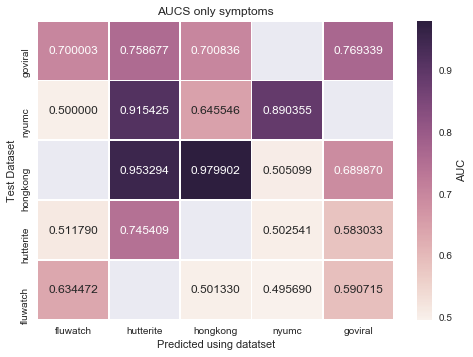

In [55]:
positive_distances = create_plots(['nyumc','goviral','fluwatch','hongkong','hutterite'],
                  results_demo,
                  'Test Dataset',
                  ['hutterite','hongkong','fluwatch','goviral','nyumc'],'AUC',
                  'AUCS only symptoms')